# Conditional GAN

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from PIL import Image
import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## Import dataset with custom loader

In [18]:
img_size = 128
data_path = './Dataset/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(),
    transforms.Resize((img_size,img_size))])

class CustomLoader(torch.utils.data.Dataset):
    def __init__(self, data_path, transform, label):
        self.path = data_path
        self.files = []
        for dir_path, currentDirectory, dir_files in os.walk(data_path):
            for file in dir_files:
                if int(file[:1]) == label:
                    self.files.append(dir_path + '/' + file)
        self.indices = len(self.files)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        label = int(self.files[idx].split('-')[0][-1:])

        return image, torch.tensor(label).long()

    def __len__(self):
        return self.indices

data_label0 = CustomLoader(data_path, transform, 0)
data_label1 = CustomLoader(data_path, transform, 1)
data_label2 = CustomLoader(data_path, transform, 2)
data_label3 = CustomLoader(data_path, transform, 3)

dataloader0 = torch.utils.data.DataLoader(data_label0, batch_size=32, shuffle=True)
dataloader1 = torch.utils.data.DataLoader(data_label1, batch_size=32, shuffle=True)
dataloader2 = torch.utils.data.DataLoader(data_label2, batch_size=32, shuffle=True)
dataloader3 = torch.utils.data.DataLoader(data_label3, batch_size=32, shuffle=True)

### Visualise one image

tensor(0)

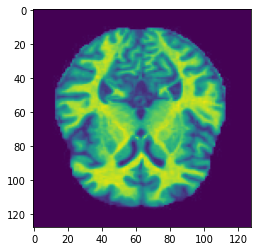

In [14]:
data = CustomLoader(data_path, transform, 0)
im, label = data[3000]
plt.imshow(im.permute(1,2,0).cpu())
label

## Create Model

In [30]:
import numpy as np
from tqdm import trange
from torch.autograd import Variable
import torch.nn as nn
import torch

latent_dim = 100
img_shape = (1, img_size, img_size)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


class GAN:
    def __init__(self, b1=0.5, b2=0.999, lr=0.0002, latent_dim=100, n_epochs=100):

        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.cuda = True if torch.cuda.is_available() else False

        self.adversarial_loss = torch.nn.BCELoss()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        if self.cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()

    def fit(self, dataloader):
        Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        logger = trange(self.n_epochs, desc=f"Epoch: 0, G_Loss: 0, D_Loss: 0")

        for epoch in logger:
            for i, (imgs, _) in enumerate(dataloader):
                valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
                fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
                real_imgs = Variable(imgs.type(Tensor))

                self.optimizer_G.zero_grad()

                z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))))

                gen_imgs = self.generator(z)

                g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)

                g_loss.backward()
                self.optimizer_G.step()

                self.optimizer_D.zero_grad()

                real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                self.optimizer_D.step()

    def generate(self, n_samples, label):
        Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        z = Variable(Tensor(np.random.normal(0, 1, (n_samples, self.latent_dim))))
        gen_imgs = self.generator(z)
        for i in range(n_samples):
            save_image(gen_imgs.data[i], f"gan_images_2/{label}/{i}.jpg", normalize=True)

## Train & Reproduce images

In [34]:
gan0 = GAN(n_epochs=100)
gan0.fit(dataloader0)
gan0.generate(2000, 0)

Epoch: 0, G_Loss: 0, D_Loss: 0: 100%|██████████| 100/100 [13:24<00:00,  8.05s/it]


In [35]:
gan1 = GAN(n_epochs=100)
gan1.fit(dataloader1)
gan1.generate(2000, 1)

Epoch: 0, G_Loss: 0, D_Loss: 0: 100%|██████████| 100/100 [09:27<00:00,  5.68s/it]


In [36]:
gan2 = GAN(n_epochs=100)
gan2.fit(dataloader2)
gan2.generate(2000, 2)

Epoch: 0, G_Loss: 0, D_Loss: 0: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


In [37]:
gan3 = GAN(n_epochs=100)
gan3.fit(dataloader3)
gan3.generate(2000, 3)

Epoch: 0, G_Loss: 0, D_Loss: 0: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


## IS score

In [13]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchvision import transforms

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy
from PIL import Image
import os

In [14]:
def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    N = len(imgs)
    dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    inception_model = inception_v3(pretrained=True, transform_input=False, progress=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(224, 224)).type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [15]:
img_size = 224
gan_path = './gan_images_2/train'
original_path = './Dataset/train'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Resize((img_size,img_size))])

class CustomLoader(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.path = data_path
        self.files = []
        for dir_path, currentDirectory, dir_files in os.walk(data_path):
            for file in dir_files[:1000]:
                self.files.append(dir_path + '/' + file)
        self.indices = len(self.files)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return self.indices

In [16]:
inception_score(CustomLoader(gan_path, transform), cuda=True, batch_size=32, resize=True, splits=1)[0] / inception_score(CustomLoader(original_path, transform), cuda=True, batch_size=32, resize=True, splits=1)[0]

1.399831018478965